# GODS 2.0 Reacher Solution

# Setup

In [1]:
%%capture
!pip install catboost logzero

# Imports

In [2]:
import pandas as  pd 
import numpy as np 
import os 
import random
import requests, zipfile

from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold

from sklearn.metrics import hamming_loss
from logzero import logger

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Download Data

In [3]:
def download(file):
  #the url and auth_value from the website 
  url = f"https://api.zindi.africa/v1/competitions/operating-system-and-browser-identification-in-tls-traffic/files/{file}"
  
  # PS : change auth token with yours
  myobj = {'auth_token': "x7nYdKyCrmLZfSkD3GJBxNkQ"} 
  x = requests.post(url, data = myobj,stream=True)
  target_path = file

  handle = open(target_path, "wb")
  for chunk in x.iter_content(chunk_size=512):
      if chunk:  # filter out keep-alive new chunks
          handle.write(chunk)
  handle.close()

In [4]:
download('Test.zip')
download('Train_one_hot.zip')
download('SampleSubmission.csv')

In [5]:
%%capture
!unzip Test.zip

In [6]:
%%capture
!unzip Train_one_hot.zip

# Utils

In [7]:
import gc
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)                    
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                elif str(col_type)[:5] == 'float':
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    gc.collect()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED=42):
  random.seed(SEED)

  np.random.seed(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)

In [9]:
seed_all()

# Configs

In [10]:
class CFG :

  lgbm_params = {
                'learning_rate': 0.05,
                'feature_fraction': 0.75,
                'num_iterations': 2000,
                'feature_fraction' : 0.8
                }
  
  n_splits = 5
  folds = StratifiedKFold(n_splits = n_splits)

# Data Processing

In [11]:
class DataProcessing :
  flags = ['ip.dsfield.ecn','ip.flags.df',]
  list_cols = ['ip.len','ip.ttl','tcp.offset','tcp.options.timestamp.tsval','tcp.window_size_value',
                          'tls.handshake.extensions_length','frame.time_epoch']
  tcp_flags = ['CWR','ECE','SYN','ACK','PSH']
  cert_curve_uniques = ['prime256v1','secp384r1']
  def __init__(self,train,test) :
    self.train = train
    self.test  = test

  def process_list_cols(self,data) :
    for col in self.list_cols :
      #cleaning 
      data[col] = data[col].apply(lambda x : x.strip('[').strip(']').split(', '))
      data[col] = data[col].apply(lambda x : ["'0'" if y=="''" else y for y in x])
      data[col] =data[col].apply(lambda x : [float(y.strip("'")) for y in x])
      #statistics features
      data[f'{col}_max'] = data[f'{col}'].apply(lambda x : np.max(x))

      data[f'{col}_min'] = data[f'{col}'].apply(lambda x : np.min(x))

      data[f'{col}_len'] = data[f'{col}'].apply(lambda x : len(x))

      data[f'{col}_mean'] = data[f'{col}'].apply(lambda x : np.mean(x))

      data[f'{col}_median'] = data[f'{col}'].apply(lambda x : np.median(x))

      data[f'{col}_std'] = data[f'{col}'].apply(lambda x : np.std(x))
    
    return data
  
  def process_flags_cols(self,data) :

    for c in self.flags :
      if c=='ip.dsfield.ecn' :
        data[f'{c}'] = data[f'{c}'].apply(lambda x : x.strip('[').strip(']').split(', '))
        data[f'{c}'] = data[f'{c}'].apply(lambda x : [int(y.strip("'")) for y in x])

        data[f'{c}_0_count'] = data[f'{c}'].apply(lambda x : x.count(0) )
        data[f'{c}_2_count'] = data[f'{c}'].apply(lambda x : x.count(2) )

        data[f'{c}_mean'] = data[f'{c}'].apply(lambda x : np.mean(x) )
        data[f'{c}_std'] = data[f'{c}'].apply(lambda x : np.std(x) )
      else :
        data[f'{c}'] = data[f'{c}'].apply(lambda x : x.strip('[').strip(']').split(', '))
        data[f'{c}'] = data[f'{c}'].apply(lambda x : [int(y.strip("'")) for y in x])

        data[f'{c}_0_count'] = data[f'{c}'].apply(lambda x : x.count(0) )
        data[f'{c}_1_count'] = data[f'{c}'].apply(lambda x : x.count(1) )

        data[f'{c}_mean'] = data[f'{c}'].apply(lambda x : np.mean(x) )
        data[f'{c}_std'] = data[f'{c}'].apply(lambda x : np.std(x) )

    return data
  
  def process_tcp_flags(self,data) :
    
    for c in self.tcp_flags :
      data[f'tcp_flag_{c}'] = (data['tcp.flags'] ==c)*1
      data[f'tcp_flag_{c}_count'] = data['tcp.flags'].apply(lambda x : x.count(c))
    return data
  def FE(self,data) :
    data['tcp.options.timestamp.tsval_diff'] = train['tcp.options.timestamp.tsval_max'] - data['tcp.options.timestamp.tsval_min']

    data['packet_directions'] = data['packet_directions'].apply(lambda x : x.strip('[').strip(']').split(', '))
    data['packet_directions_I_count'] = data['packet_directions'].apply(lambda x : x.count("'I'") )

    data['packet_directions_O_count'] = data['packet_directions'].apply(lambda x : x.count("'O'") )

    data['packet_directions_len'] = data['packet_directions'].apply(lambda x : len(x) )
    for c in self.cert_curve_uniques : 
      data[c] = data['cert.curve'].fillna('').str.contains(c)*1

    data['cert.curve_len'] = data['cert.curve'].fillna('').apply(lambda x : len(x))
    #ohe Encode
    tls_vers = ['TLS 1.3','TLS 1.2','Reserved (GREASE)','TLS 1.1','TLS 1.0',]
    for c in tls_vers :
      data[c] = data['tls.handshake.extensions.supported_version.ch'].str.contains(c)*1
    #ohe 
    tls_ch = ['h2','http/1.1']
    for c in tls_vers :
      data[c] = data['tls.handshake.extensions_alpn_str.ch'].str.contains(c)*1
    #Label enc
    sh_mapper = {'http/1.1' :0,'h2':1}
    data['tls.handshake.extensions_alpn_str.sh'] = data['tls.handshake.extensions_alpn_str.sh'].map(sh_mapper)
    #Label Enc
    format_ch_mapper = {"['0']" :0,"['0', '1', '2']":1}
    data['tls.handshake.extensions_ec_point_format.ch'] = data['tls.handshake.extensions_ec_point_format.ch'].map(format_ch_mapper)
    data['tls.handshake.extensions_ec_point_format.sh'] = data['tls.handshake.extensions_ec_point_format.sh'].map(format_ch_mapper)
    #Label Enc
    tls_handshake_mapper = {'TLSv1.2' :0,'TLSv1.3':1}
    data['tls.handshake.version.sh'] = data['tls.handshake.version.sh'].map(tls_handshake_mapper)
    #ohe
    for c in tls_vers :
      data[f'tls.record.version.ch_{c}'] = data['tls.record.version.ch'].str.contains(c)*1
    return data

  def get_tf_idf_feats(self,train,test) :
      from sklearn.feature_extraction.text import TfidfVectorizer
      vect = TfidfVectorizer(max_features=10,analyzer='char')
      feats = vect.fit_transform(train['tls.cipher'])
      train = pd.concat([train,pd.DataFrame(feats.todense(),columns=vect.get_feature_names())],1)
      test = pd.concat([test,pd.DataFrame(vect.transform(test['tls.cipher']).todense(),columns=vect.get_feature_names())],1)  
      return train,test


    





  

  def process(self,) :
    self.train = reduce_mem_usage(self.train)
    self.test  = reduce_mem_usage(self.test)
    logger.info(f"Processing Data")
    self.train = self.process_list_cols(self.train)
    self.test = self.process_list_cols(self.test)

    logger.info(f"Added statistics about tcp tls and ip logs ")
    self.train = self.process_flags_cols(self.train)
    self.test = self.process_flags_cols(self.test)

    logger.info(f"Added flags features ")

    self.train = self.process_tcp_flags(self.train)
    self.test = self.process_tcp_flags(self.test)

    logger.info(f"Added tcp flags features ")
    logger.info(f"Feature Engineering ")

    self.train = self.FE(self.train)
    self.test = self.FE(self.test)
    
    self.train,self.test = self.get_tf_idf_feats(self.train,self.test)
    logger.info(f"Added TF-IDF Features ")
    
    # Get 
        
    self.train = reduce_mem_usage(self.train)
    self.test  = reduce_mem_usage(self.test)
    
    return self.train, self.test

In [12]:
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')

In [13]:
%%time
processor = DataProcessing(train,test)
train,test = processor.process()

Memory usage of dataframe is 145.89 MB


[I 230220 17:45:05 <ipython-input-11-a4a1a15a020a>:118] Processing Data


Memory usage after optimization is: 118.07 MB
Decreased by 19.1%
Memory usage of dataframe is 53.59 MB
Memory usage after optimization is: 53.59 MB
Decreased by 0.0%


[I 230220 17:51:42 <ipython-input-11-a4a1a15a020a>:122] Added statistics about tcp tls and ip logs 
[I 230220 17:52:45 <ipython-input-11-a4a1a15a020a>:126] Added flags features 
[I 230220 17:52:48 <ipython-input-11-a4a1a15a020a>:131] Added tcp flags features 
[I 230220 17:52:48 <ipython-input-11-a4a1a15a020a>:132] Feature Engineering 
[I 230220 17:53:04 <ipython-input-11-a4a1a15a020a>:138] Added TF-IDF Features 


Memory usage of dataframe is 333.19 MB
Memory usage after optimization is: 160.11 MB
Decreased by 51.9%
Memory usage of dataframe is 159.54 MB
Memory usage after optimization is: 74.44 MB
Decreased by 53.3%
CPU times: user 8min 1s, sys: 12.5 s, total: 8min 13s
Wall time: 8min 8s


In [14]:
CFG.TARGETS = ['linux_centos-7','linux_opensuse-15.4','linux_ubuntu-22.04.1','macos_big-sur','macos_catalina',
           'macos_monterey','windows_windows-10','windows_windows-11','windows_windows-7','windows_windows-server-2012',
           'windows_windows-server-2012-r2','chrome','edge','firefox','opera'] 

In [15]:
CFG.FEATURES = train.columns.difference(['ID','cert.alt','cert.curve','cert.hash','cert.issuerCN','cert.issuerON','cert.notAfter',
'cert.notBefore','cert.publicAlgorithm','cert.publicAlgorithm','cert.serial','cert.subjectCN','cert.subjectON','cert.validDays',
'ip.dsfield.dscp','ip.dsfield.ecn','ip.flags.df','ip.id','ip.len','ip.ttl','tcp.flags','tcp.offset','tcp.options.timestamp.tsval',
'tcp.window_size_value','tls.cipher','tls.handshake.ciphersuite.ch','tls.handshake.extension.len','tls.handshake.extension.type',
'tls.handshake.extensions.supported_version.ch','tls.handshake.extensions_alpn_str.ch','tls.handshake.extensions_alpn_str.sh',
'tls.handshake.extensions_length','tls.handshake.extensions_supported_group.ch','tls.handshake.sig_hash_alg.ch','tls.handshake.version.ch','tls.ja3',
'tls.ja3s','tls.record.version.ch','frame.time_epoch','packet_directions','OS','browser','cert.remainingDays','tls.handshake.type','tls.handshake.extensions_ec_point_format.ch',
'tls.handshake.extensions_ec_point_format.sh','tls.handshake.version.sh'] + CFG.TARGETS).tolist()

In [16]:
train[CFG.FEATURES].head()

,2,5,Reserved (GREASE),TLS 1.0,TLS 1.1,TLS 1.2,TLS 1.3,_,a,c,cert.curve_len,e,frame.time_epoch_len,frame.time_epoch_max,frame.time_epoch_mean,frame.time_epoch_median,frame.time_epoch_min,frame.time_epoch_std,h,ip.dsfield.ecn_0_count,ip.dsfield.ecn_2_count,ip.dsfield.ecn_mean,ip.dsfield.ecn_std,ip.flags.df_0_count,ip.flags.df_1_count,ip.flags.df_mean,ip.flags.df_std,ip.len_len,ip.len_max,ip.len_mean,ip.len_median,ip.len_min,ip.len_std,ip.ttl_len,ip.ttl_max,ip.ttl_mean,ip.ttl_median,ip.ttl_min,ip.ttl_std,l,packet_directions_I_count,packet_directions_O_count,packet_directions_len,prime256v1,s,secp384r1,t,tcp.offset_len,tcp.offset_max,tcp.offset_mean,tcp.offset_median,tcp.offset_min,tcp.offset_std,tcp.options.timestamp.tsval_diff,tcp.options.timestamp.tsval_len,tcp.options.timestamp.tsval_max,tcp.options.timestamp.tsval_mean,tcp.options.timestamp.tsval_median,tcp.options.timestamp.tsval_min,tcp.options.timestamp.tsval_std,tcp.window_size_value_len,tcp.window_size_value_max,tcp.window_size_value_mean,tcp.window_size_value_median,tcp.window_size_value_min,tcp.window_size_value_std,tcp_flag_ACK,tcp_flag_ACK_count,tcp_flag_CWR,tcp_flag_CWR_count,tcp_flag_ECE,tcp_flag_ECE_count,tcp_flag_PSH,tcp_flag_PSH_count,tcp_flag_SYN,tcp_flag_SYN_count,tls.handshake.extensions_length_len,tls.handshake.extensions_length_max,tls.handshake.extensions_length_mean,tls.handshake.extensions_length_median,tls.handshake.extensions_length_min,tls.handshake.extensions_length_std,tls.record.version.ch_Reserved (GREASE),tls.record.version.ch_TLS 1.0,tls.record.version.ch_TLS 1.1,tls.record.version.ch_TLS 1.2,tls.record.version.ch_TLS 1.3
0,0.318604,0.159424,0,0,0,0,0,0.637207,0.318604,0.159302,0,0.187134,20,1.664377e+09,1.664377e+09,1.664377e+09,1.664377e+09,0.069641,0.159302,19,1,0.099976,0.435791,0,20,1.0,0.0,20,1174.0,330.000,58.0,40.0,432.50,20,128.0,95.50000,95.5,63.0,32.500000,0.159302,10,9,19,0,0.478027,0,0.159302,20,32.0,21.203125,20.0,20.0,3.599609,0.000000e+00,20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20,64240.0,3850.0,254.0,251.0,13960.0,0,19,0,1,0,1,0,8,0,2,20,401.0,22.343750,0.0,0.0,87.43750,0,1,0,0,0
1,0.096924,0.097046,0,0,0,0,0,0.678711,0.290771,0.193848,0,0.341553,45,1.663859e+09,1.663859e+09,1.663859e+09,1.663859e+09,46.312500,0.290771,45,0,0.000000,0.000000,0,45,1.0,0.0,45,3418.0,183.875,52.0,40.0,511.50,45,64.0,63.53125,64.0,63.0,0.498779,0.096924,21,23,44,0,0.387695,0,0.193848,45,40.0,31.828125,32.0,20.0,3.035156,3.334123e+09,45,3.334123e+09,1.778851e+09,4.561277e+08,0.000000e+00,1.457669e+09,45,65160.0,3220.0,485.0,0.0,13264.0,0,42,0,0,0,0,0,9,0,2,45,401.0,9.796875,0.0,0.0,59.28125,0,1,0,0,0
2,0.318604,0.159424,0,0,0,0,0,0.637207,0.318604,0.159302,0,0.187134,37,1.663858e+09,1.663858e+09,1.663858e+09,1.663858e+09,0.123779,0.159302,37,0,0.000000,0.000000,0,37,1.0,0.0,37,3166.0,264.000,60.0,52.0,557.00,37,64.0,63.56250,64.0,63.0,0.495361,0.159302,16,20,36,0,0.478027,0,0.159302,37,40.0,32.437500,32.0,32.0,1.808594,2.579437e+09,37,3.332622e+09,1.868618e+09,7.531857e+08,7.531853e+08,1.277888e+09,37,65160.0,3870.0,501.0,251.0,14544.0,0,36,0,0,0,0,0,17,0,2,37,401.0,12.078125,0.0,0.0,65.25000,0,1,0,0,0
3,0.288574,0.288818,0,0,0,0,0,0.433105,0.433105,0.288574,0,0.000000,30,1.675352e+09,1.675352e+09,1.675352e+09,1.675352e+09,0.964355,0.433105,30,0,0.000000,0.000000,0,30,1.0,0.0,30,1174.0,262.750,52.0,40.0,359.25,30,128.0,93.31250,63.0,63.0,32.437500,0.288574,16,13,29,0,0.288574,0,0.144287,30,32.0,20.796875,20.0,20.0,2.994141,0.000000e+00,30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,30,64240.0,4852.0,637.0,251.0,15880.0,0,29,0,0,0,0,0,12,0,2,30,403.0,14.968750,0.0,0.0,72.50000,0,1,0,0,0
4,0.191162,0.095703,0,0,0,0,0,0.669434,0.286865,0.191162,0,0.336914,30,1.675331e+09,1.675331e+09,1.675331e+09,1.675331e+09,0.324463,0.286865,16,14,0.933105,0.997559,0,30,1.0,0.0,30,1174.0,308.250,62.0,52.0,395.50,30,64.0,63.46875,63.0,63.0,0.498779,0.095581,16,13,29,0,0.382324,0,0.191162,30,44.0,32.656250,32.0,32.0,2.54

# Modeling

In [17]:
# We will train two classification models (for os and browser)
train['OS'] = train[CFG.TARGETS].iloc[:,:-4].idxmax(axis=1)
train['browser'] = train[CFG.TARGETS].iloc[:,-4 :].idxmax(axis=1)

In [18]:
oof = train[['OS','browser']]
folds = CFG.folds
preds1=[]
preds2 = []
X= train[CFG.FEATURES]
TEST= test[CFG.FEATURES]
for j,targ in enumerate(['OS','browser']) : 
  y = train[targ]
  print(50*'--')
  print(f'Training k-Fold Model for Target {targ}')
  print(50*'--')
  for i,( train_index, test_index) in enumerate(folds.split(X, y)):

      print(50*'--')
      print(f'Fold {i+1}/{5}')
      print(50*'--')

      X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

      # Train model

      model = LGBMClassifier(n_estimators=2000,class_weight='balanced',feature_fraction=0.3)
      model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100,early_stopping_rounds=50)

      # Fold Evaluation

      fold_pred   = model.predict(X_test)
     
      #update oof
      oof.loc[test_index,f'preds_{targ}'] = fold_pred

      # Test Evaluation
      test_proba = model.predict_proba(TEST)
      if j==0 :
        preds1.append(test_proba)
      else :
        preds2.append(test_proba)

----------------------------------------------------------------------------------------------------
Training k-Fold Model for Target OS
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold 1/5
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.151105	valid_1's multi_logloss: 0.166286
[200]	training's multi_logloss: 0.13159	valid_1's multi_logloss: 0.159389
[300]	training's multi_logloss: 0.117691	valid_1's multi_logloss: 0.156429
[400]	training's multi_logloss: 0.106751	valid_1's multi_logloss: 0.154811
[500]	training's multi_logloss: 0.097421	valid_1's multi_logloss: 0.153752
[600]	training's multi_logloss: 0.088933	valid_1's multi_logloss: 0.152743
[700]	training's multi_logloss: 0.081804

## Compute CV

In [19]:
cv_loss = hamming_loss(pd.get_dummies(oof).iloc[:,:15],pd.get_dummies(oof).iloc[:,15:])
print(f'Our cross validation score is {cv_loss}')

Our cross validation score is 0.01091724030825972


## Lets viualize last model Features Importances

In [20]:
feats_importance = pd.DataFrame()
feats_importance['Importances'] = model.feature_importances_
feats_importance['features'] = X.columns

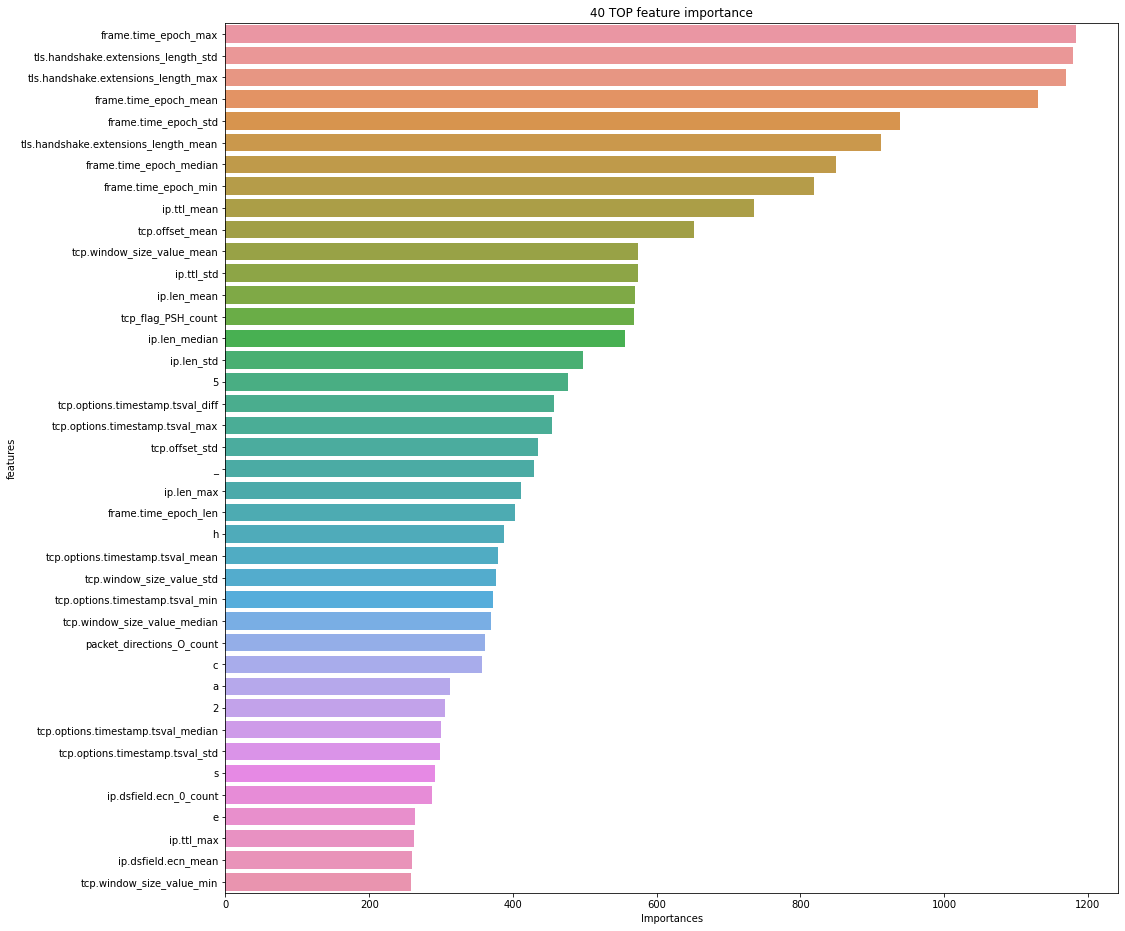

In [21]:
n_top_feats = 40
plt.figure(figsize=(16, 16))
sns.barplot(data=feats_importance.sort_values(by='Importances', ascending=False).head(n_top_feats), x='Importances', y='features');
plt.title(f'{n_top_feats} TOP feature importance');

## Making Submission File

In [22]:
sub1 = pd.DataFrame(np.mean(preds1,0),columns=CFG.TARGETS[:11])
sub2 = pd.DataFrame(np.mean(preds2,0),columns=CFG.TARGETS[11:])
sub = pd.concat([sub1,sub2],1)
for c in CFG.TARGETS :
  sub[c] = (sub[c]>0.5)*1.0
sub['ID'] = test['ID']
sub.insert(0, 'ID', sub.pop('ID'))

In [23]:
sub

,ID,linux_centos-7,linux_opensuse-15.4,linux_ubuntu-22.04.1,macos_big-sur,macos_catalina,macos_monterey,windows_windows-10,windows_windows-11,windows_windows-7,windows_windows-server-2012,windows_windows-server-2012-r2,chrome,edge,firefox,opera
0,ID_431730,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ID_339338,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ID_085257,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ID_274334,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ID_037555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159626,ID_111103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
159627,ID_260615,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
159628,ID_017565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
159629,ID_352796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
sub.to_csv('GODS_Reacher_solution.csv',index=False)